# EDA Station 24, 25 and 36
This notebook attempts to separate station 24, 25 and station 36 into substations where all the samples have the same timestamp.

In [1]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [2]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [3]:
date_info = func.get_station_info(const.TRAIN_FILES[2])

In [4]:
date_data = func.load_data_file(const.TRAIN_FILES[2], ftype='csv')

Returning train_date.csv


In [5]:
date_data.set_index('Id', inplace=True)

In [6]:
date_data = date_data.transpose()

In [7]:
date_data = date_data.merge(date_info, how='left', left_index=True, right_on='name')

In [8]:
date_data.head()

Id,4,6,7,9,11,13,14,16,18,23,...,2367488,2367490,2367491,2367492,2367493,2367495,line,station,feature_nr,name
0,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,1,L0_S0_D1
1,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,3,L0_S0_D3
2,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,5,L0_S0_D5
3,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,7,L0_S0_D7
4,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,9,L0_S0_D9


## Functions

In [9]:
def plot_shifts_and_sample_counts(data_set, title_tag=''):
    '''Plots the number of NA's per feature in a station and possible cut points for substations '''
    mean_dt = data_set.fillna(method='ffill').diff().mean(1)
    shifts = mean_dt[mean_dt>0].index.values
    
    shift_ax = [data_set.index.get_loc(n) for n in shifts]
    
    f = plt.figure(figsize=(16,6))
    ax = (data_set.isnull().sum(1)/data_set.shape[1]).plot(kind='bar')
    ax.set_ylabel('Percentage NA samples')
    ax.set_ylim([0, 1])
    ax.set_title('Station timeline for entry point {}'.format(title_tag))
    ymin, ymax = ax.get_ylim()
    #for shift in shifts:
        #print shift
    ax.vlines(x=shift_ax, ymin=ymin, ymax=ymax, linewidth=2, color='k')#ax.set_ylim([0, 250])
    
    return shifts

In [10]:
def post_process(df):
    df.drop(['line','station','name'], axis=1, inplace=True)
    df.set_index('feature_nr', inplace=True)
    
    # Remove samples with only na data in column
    no_info = df.isnull().sum()==df.shape[0]
    df = df.loc[:,~no_info]
    
    # Set all timestamps to t=0
    df = df.apply(lambda x: x - x.min(), axis=0)
    
    return df

## Split data in station 24, station 25 and station 36

In [11]:
# Split data in station 24 and station 25
date_data_24 = post_process(date_data[(date_data.line==1) & (date_data.station==24)])
date_data_25 = post_process(date_data[(date_data.line==1) & (date_data.station==25)])
date_data_36 = post_process(date_data[(date_data.line==3) & (date_data.station==36)])

/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [12]:
del date_data

## Analyze station 36

In [13]:
print('Number of samples station 36: {}'.format(date_data_36.shape[1]))
print('Feature nr from {} to {}'.format(date_data_36.index.min(), date_data_36.index.max()))

Number of samples station 36: 569032
Feature nr from 3919 to 3940


In [14]:
# Look at entry station for station 36
entries36 = date_data_36.apply(lambda x: x.first_valid_index()).value_counts()
print(entries36)

3919    569031
3928         1
dtype: int64


In [15]:
# Look at exits of station 24
exits36 = date_data_36.apply(lambda x: x.last_valid_index()).value_counts()
print(exits36)

3940    569032
dtype: int64


In [16]:
date_data_36.loc[:,date_data_36.loc[3919,:].isnull()]

Id,435812
feature_nr,
3919,NaN
3921,NaN
3923,NaN
3925,NaN
3928,0.0
3932,0.0
3936,0.0
3940,0.0


## Analyze station 24

In [17]:
print('Number of samples station 24: {}'.format(date_data_24.shape[1]))
print('Feature nr from {} to {}'.format(date_data_24.index.min(), date_data_24.index.max()))

Number of samples station 24: 183727
Feature nr from 677 to 1851


In [18]:
# Look at entry station for station 24
entries24 = date_data_24.apply(lambda x: x.first_valid_index()).value_counts()
print(entries24)

1511    132669
1116     27178
677      23862
1826         8
1765         4
1809         3
1583         1
1568         1
1566         1
dtype: int64


In [19]:
# Look at exits of station 24
exits24 = date_data_24.apply(lambda x: x.last_valid_index()).value_counts()
print(exits24)

1851    132922
1508     27052
1112     23750
1568         2
1805         1
dtype: int64


In [20]:
# Look at exit station per major entry station

for ix, entry in entries24[:3].iteritems():
    print('Exit stations for {}'.format(ix))
    print(date_data_24.loc[:,~date_data_24.loc[ix,:].isnull()] \
                                                       .apply(lambda x: x.last_valid_index()).value_counts()) \
                                                       / entry
    print('')


Exit stations for 1511
1851    1.001771
1568    0.000015
1805    0.000008
dtype: float64

Exit stations for 1116
1508    0.995364
1851    0.005519
dtype: float64

Exit stations for 677
1112    0.995306
1851    0.003688
1508    0.001006
dtype: float64



This shows two things:
1. Samples that enter via one station, exit 99% of the time a specific station. So 99%+ of the samples in Station 24 follow on of these three paths..
2. The entry and exit stations are not overlapping. So more than 99% of the samples follow only one of these three paths.

Let's see how similar these three paths are:

In [21]:
# Load feature look-up table to see how many numeric/categorical features there are
date_info = pd.read_csv(os.path.join(const.DATA_PATH, 'date_feat_lut.csv'))
date_info.head()

,line,station,feature_nr,feat_nr_dat,name_dat,name_cat,name_num
0,0,0,0,1.0,L0_S0_D1,NaN,L0_S0_F0
1,0,0,2,3.0,L0_S0_D3,NaN,L0_S0_F2
2,0,0,4,5.0,L0_S0_D5,NaN,L0_S0_F4
3,0,0,6,7.0,L0_S0_D7,NaN,L0_S0_F6
4,0,0,8,9.0,L0_S0_D9,NaN,L0_S0_F8


In [22]:
for entry, exit in zip(entries24[:3].index.values, exits24[:3].index.values):
    print('Feature analysis for entry point {}'.format(entry))
    fea = date_info[(date_info.feature_nr>=entry) & (date_info.feature_nr<=exit)]
    print('Number of date features: {}'.format((~fea.name_dat.isnull()).sum()))
    print('Number of cat features: {}'.format((~fea.name_cat.isnull()).sum()))
    print('Number of num features: {}'.format((~fea.name_num.isnull()).sum()))
    print fea.shape
    print('')

Feature analysis for entry point 1511
Number of date features: 91
Number of cat features: 176
Number of num features: 73
(251, 7)

Feature analysis for entry point 1116
Number of date features: 91
Number of cat features: 228
Number of num features: 73
(301, 7)

Feature analysis for entry point 677
Number of date features: 103
Number of cat features: 249
Number of num features: 83
(332, 7)



They are very similar, but not the same, so we cannot shift them...:()

In [23]:
# So update entries and exit values
entries24 = [677, 1116, 1511]
exits24 = [1112, 1508, 1851]

Station break points for entry point 677
11 station breaks found: [ 697  702  801  804  807  813  818  909  999 1018 1062]

Station break points for entry point 1116
11 station breaks found: [1135 1158 1163 1168 1171 1178 1186 1277 1368 1413 1457]

Station break points for entry point 1511
11 station breaks found: [1522 1562 1566 1568 1570 1576 1583 1674 1765 1809 1826]



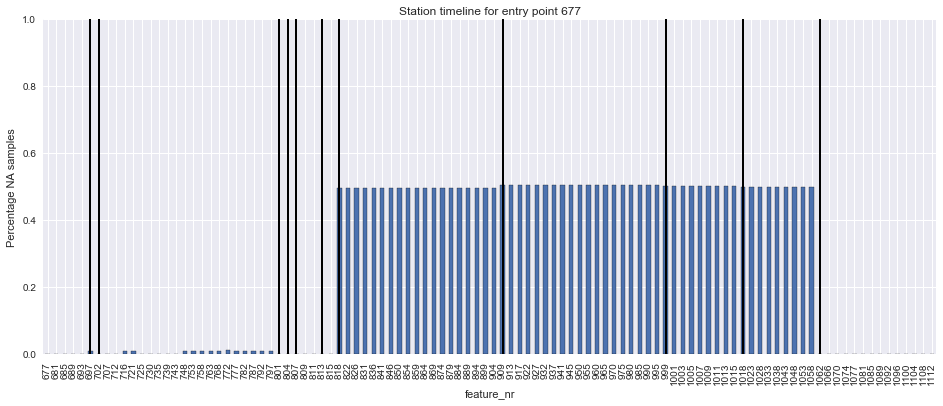

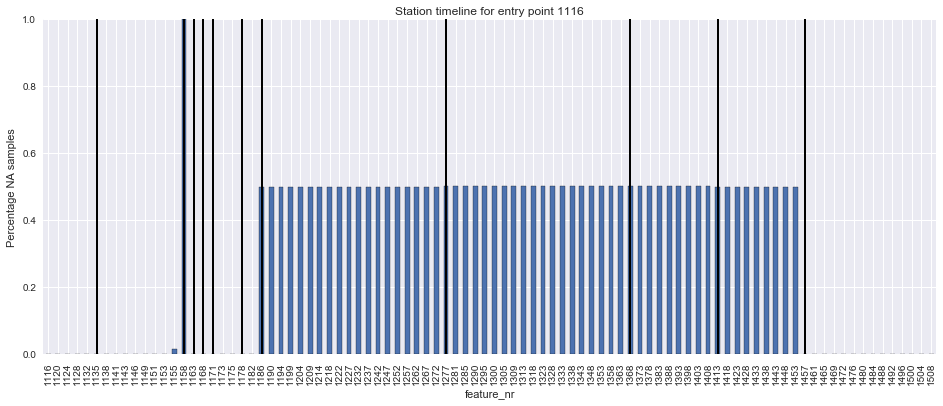

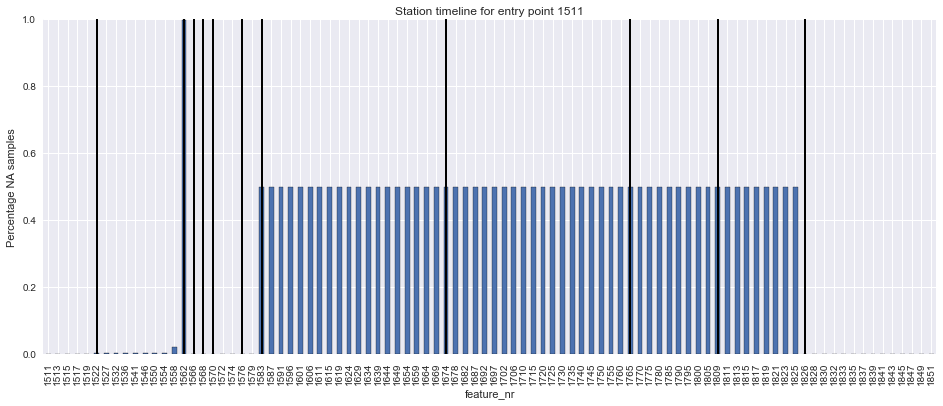

In [24]:
# Look for the break points and plot number of samples over the features
station_breaks_24 = []
for entry, exit in zip(entries24, exits24):
    print('Station break points for entry point {}'.format(entry))
    
    df = date_data_24.loc[entry:exit+1, :]
    
    # Include only samples with at least one value in this range
    df = df.loc[:,~(df.isnull().sum(0)==df.shape[0])]
    
    station_breaks = plot_shifts_and_sample_counts(df, entry)
    station_breaks_24.append(station_breaks)
    
    print('{} station breaks found: {}'.format(len(station_breaks),station_breaks)) 
    
    print('')
    

## Analyze station 25

In [25]:
print('Number of samples station 25: {}'.format(date_data_25.shape[1]))
print('Feature nr from {} to {}'.format(date_data_25.index.min(), date_data_25.index.max()))

Number of samples station 25: 83658
Feature nr from 1854 to 3035


In [26]:
# Look at entry station for station 25
entries25 = date_data_25.apply(lambda x: x.first_valid_index()).value_counts()
print(entries25)

1854    55466
2471     9855
2230     6066
2206     3611
2780     3327
2754     2475
2497     1596
2180     1243
1867       17
2238        1
2788        1
dtype: int64


In [27]:
# Look at exits of station 25
exits25 = date_data_25.apply(lambda x: x.last_valid_index()).value_counts()
print(exits25)

2178    54516
3035    17772
2469     7005
2752     4262
2093       34
2133       22
1879        7
1898        7
1883        6
2228        5
2874        3
2778        3
2992        3
1975        3
1887        2
1895        2
2204        1
2444        1
2952        1
2053        1
3010        1
2495        1
dtype: int64


So this one is little bit more complicated. There is one clear path (entry 1854 + exit at 2178), but the remaining paths are less clear. Lets look at exits for the Top7 entry points.

In [28]:
# Look at exit station per major entry station

for ix, entry in entries25[:7].iteritems():
    print('Exit stations for {}'.format(ix))
    print(date_data_25.loc[:,~date_data_25.loc[ix,:].isnull()] \
                                                       .apply(lambda x: x.last_valid_index()).value_counts()) \
                                                       / entry
    print('')

Exit stations for 1854
2178    0.982566
3035    0.006148
2752    0.005499
2469    0.004273
2093    0.000613
2133    0.000397
1879    0.000126
1898    0.000126
1883    0.000108
1975    0.000054
1887    0.000036
1895    0.000036
2053    0.000018
dtype: float64

Exit stations for 2471
3035    0.818569
2752    0.182243
2495    0.000101
dtype: float64

Exit stations for 2230
2469    1.154468
3035    0.023904
2752    0.001484
2444    0.000165
dtype: float64

Exit stations for 2206
3035    0.721684
2469    0.223484
2752    0.054556
2228    0.001385
2444    0.000277
dtype: float64

Exit stations for 2780
3035    5.341148
2874    0.000902
2992    0.000902
2952    0.000301
3010    0.000301
dtype: float64

Exit stations for 2754
3035    0.999192
2778    0.001212
2992    0.000404
dtype: float64

Exit stations for 2497
2752    2.670426
3035    0.021930
dtype: float64



In [29]:
# Look at entry station per major exit station

for ix, exit in exits25[:3].iteritems():
    print('Entry stations for exit {}'.format(ix))
    print(date_data_25.loc[:,~date_data_25.loc[ix,:].isnull()] \
                                                       .apply(lambda x: x.first_valid_index()).value_counts()) \
                                                       / exit
    print('')

Entry stations for exit 2178
1854    1.008420
1867    0.000312
dtype: float64

Entry stations for exit 3035
2471    0.453522
2780    0.186811
2206    0.146466
2754    0.139039
2180    0.047716
1854    0.019187
2230    0.006752
2497    0.000450
2788    0.000056
dtype: float64

Entry stations for exit 2469
2230    0.855246
2206    0.115489
1854    0.033833
2180    0.003426
2238    0.000143
dtype: float64



There is one clear path (entry 1854 + exit at 2178) that is nicely separated from the others, but the others are quite messy. No further separation based on this analysis. In this case set exists and entries manually.

In [30]:
entries25 = [1854, 2179]
exits25 = [2178, 3035]

Feature analysis for entry point 1854
10 station breaks found: [1867 1883 1887 1891 1898 1902 1980 2058 2098 2138]

Feature analysis for entry point 2179
30 station breaks found: [2206 2230 2238 2240 2248 2251 2329 2406 2430 2445 2471 2497 2505 2507 2515
 2518 2596 2674 2713 2728 2754 2780 2788 2790 2798 2801 2879 2957 2996 3011]



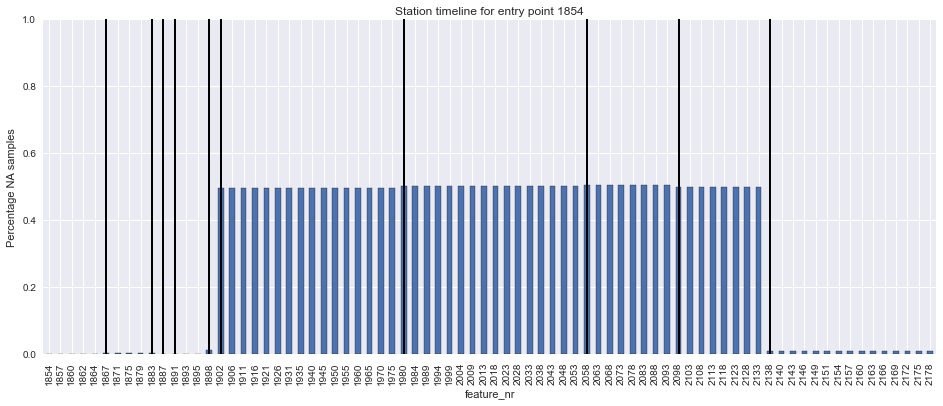

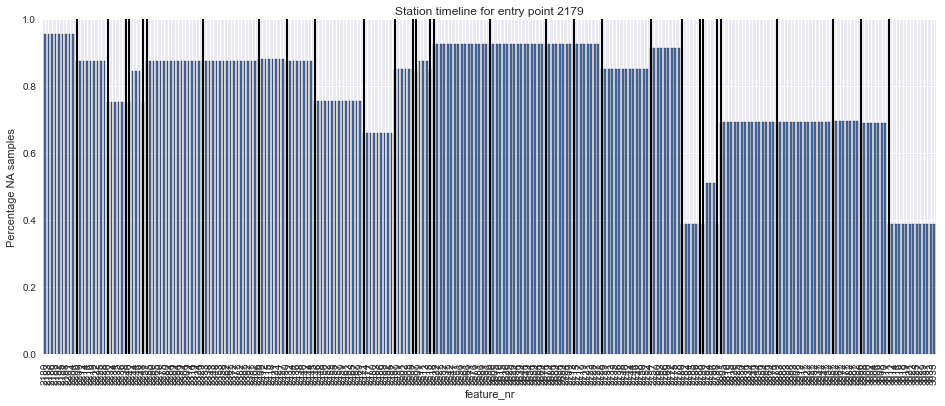

In [31]:
# Look for the break points and plot number of samples over the features
station_breaks_25 = []
for entry, exit in zip(entries25, exits25):
    print('Feature analysis for entry point {}'.format(entry))
    
    df = date_data_25.loc[entry:exit+1, :]
    
    # Include only samples with at least one value in this range
    df = df.loc[:,~(df.isnull().sum(0)==df.shape[0])]
    
    station_breaks = plot_shifts_and_sample_counts(df, entry)
    station_breaks_25.append(station_breaks)
    
    print('{} station breaks found: {}'.format(len(station_breaks),station_breaks)) 
    
    print('')

## Update look-up table with newly determined stations
We need to update the look-up table and insert new stations for Station 24 and 25 and update the station after station 25.

In [32]:
# Current look up table
date_info.head()

,line,station,feature_nr,feat_nr_dat,name_dat,name_cat,name_num
0,0,0,0,1.0,L0_S0_D1,NaN,L0_S0_F0
1,0,0,2,3.0,L0_S0_D3,NaN,L0_S0_F2
2,0,0,4,5.0,L0_S0_D5,NaN,L0_S0_F4
3,0,0,6,7.0,L0_S0_D7,NaN,L0_S0_F6
4,0,0,8,9.0,L0_S0_D9,NaN,L0_S0_F8


In [33]:
# Create new column for updated verions
date_info['station_V2'] = date_info['station']

### Insert station 24

In [34]:
# Find first feature of station 24
first_feature = date_info[date_info.station==24].iloc[0].feature_nr
date_info[date_info.station==24].iloc[0] 

line                     1
station                 24
feature_nr             675
feat_nr_dat            NaN
name_dat               NaN
name_cat       L1_S24_F675
name_num               NaN
station_V2              24
Name: 497, dtype: object

In [35]:
# Find first feature of station 24
last_feature = date_info[date_info.station==24].iloc[-1].feature_nr
date_info[date_info.station==24].iloc[-1] 

line                      1
station                  24
feature_nr             1850
feat_nr_dat            1851
name_dat       L1_S24_D1851
name_cat                NaN
name_num       L1_S24_F1850
station_V2               24
Name: 1387, dtype: object

In [36]:
station_breaks_24

[array([ 697,  702,  801,  804,  807,  813,  818,  909,  999, 1018, 1062]),
 array([1135, 1158, 1163, 1168, 1171, 1178, 1186, 1277, 1368, 1413, 1457]),
 array([1522, 1562, 1566, 1568, 1570, 1576, 1583, 1674, 1765, 1809, 1826])]

In [37]:
# Update first feature
station_nr = 24.1
date_info.loc[date_info.feature_nr==first_feature, 'station_V2'] = station_nr

In [39]:
# Update all features
for entry, exit, substations in zip(entries24, exits24, station_breaks_24):
    #print('\nNew substation')
    
    # Update first entry
    #fs = date_info[date_info.feat_nr_dat==entry].feature_nr.values[0]
    fe = date_info[date_info.feat_nr_dat==substations[0]].feature_nr.values[0]
    date_info.loc[(date_info.feature_nr>first_feature) & (date_info.feature_nr<fe),'station_V2'] = station_nr
    
    for i in range(substations.shape[0]-1):
        station_nr += 0.001
        
        
        #print entry, station_break, station_nr
        
        # Find feature_number for this range
        fs = date_info[date_info.feat_nr_dat==substations[i]].feature_nr.values[0]
        fe = date_info[date_info.feat_nr_dat==substations[i+1]].feature_nr.values[0]
        
        # Update frame
        date_info.loc[(date_info.feature_nr>=fs) & (date_info.feature_nr<fe),'station_V2'] = station_nr
        
        # Prepare next loop
        #entry = station_break
        first_feature = fe
    
    # Update last one including exit
    fs = date_info[date_info.feat_nr_dat==substations[i+1]].feature_nr.values[0]
    fe = date_info[date_info.feat_nr_dat==exit].feature_nr.values[0]
    
    # Update frame
    date_info.loc[(date_info.feature_nr>=fs) & (date_info.feature_nr<=fe),'station_V2'] = station_nr + 0.001
    
    first_feature = fe
    station_nr = round(station_nr + 0.1,1)

In [40]:
# Update last feature
date_info.loc[date_info.feature_nr==last_feature, 'station_V2'] = date_info.loc[date_info.station==24].station_V2.max()

### Insert station 25

In [41]:
# Find first feature of station 25
first_feature = date_info[date_info.station==25].iloc[0].feature_nr
date_info[date_info.station==25].iloc[0] 

line                      1
station                  25
feature_nr             1852
feat_nr_dat             NaN
name_dat                NaN
name_cat       L1_S25_F1852
name_num                NaN
station_V2               25
Name: 1388, dtype: object

In [42]:
# Find first feature of station 25
last_feature = date_info[date_info.station==25].iloc[-1].feature_nr
date_info[date_info.station==25].iloc[-1] 

line                      1
station                  25
feature_nr             3034
feat_nr_dat            3035
name_dat       L1_S25_D3035
name_cat                NaN
name_num       L1_S25_F3034
station_V2               25
Name: 2253, dtype: object

In [43]:
station_breaks_25

[array([1867, 1883, 1887, 1891, 1898, 1902, 1980, 2058, 2098, 2138]),
 array([2206, 2230, 2238, 2240, 2248, 2251, 2329, 2406, 2430, 2445, 2471,
        2497, 2505, 2507, 2515, 2518, 2596, 2674, 2713, 2728, 2754, 2780,
        2788, 2790, 2798, 2801, 2879, 2957, 2996, 3011])]

In [44]:
# Update first feature
station_nr = 25.1
date_info.loc[date_info.feature_nr==first_feature, 'station_V2'] = station_nr

In [45]:
# Update all features
for entry, exit, substations in zip(entries25, exits25, station_breaks_25):
    #print('\nNew substation')
    
    # Update first entry
    #fs = date_info[date_info.feat_nr_dat==entry].feature_nr.values[0]
    fe = date_info[date_info.feat_nr_dat==substations[0]].feature_nr.values[0]
    date_info.loc[(date_info.feature_nr>first_feature) & (date_info.feature_nr<fe),'station_V2'] = station_nr
    
    for i in range(substations.shape[0]-1):
        station_nr += 0.001
        
        
        #print entry, station_break, station_nr
        
        # Find feature_number for this range
        fs = date_info[date_info.feat_nr_dat==substations[i]].feature_nr.values[0]
        fe = date_info[date_info.feat_nr_dat==substations[i+1]].feature_nr.values[0]
        
        # Update frame
        date_info.loc[(date_info.feature_nr>=fs) & (date_info.feature_nr<fe),'station_V2'] = station_nr
        
        # Prepare next loop
        #entry = station_break
        first_feature = fe
    
    # Update last one including exit
    fs = date_info[date_info.feat_nr_dat==substations[i+1]].feature_nr.values[0]
    fe = date_info[date_info.feat_nr_dat==exit].feature_nr.values[0]
    
    # Update frame
    date_info.loc[(date_info.feature_nr>=fs) & (date_info.feature_nr<=fe),'station_V2'] = station_nr + 0.001
    
    first_feature = fe
    station_nr = round(station_nr + 0.1,1)

In [46]:
# Update last feature
date_info.loc[date_info.feature_nr==last_feature, 'station_V2'] = date_info.loc[date_info.station==25].station_V2.max()

### Export

In [47]:
date_info.to_csv(os.path.join(const.DATA_PATH, 'date_feat_lut_V2.csv'), index=False)